In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/reanalysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir)
from utils import split_obs
from exp_hp import get_hp

2025-01-31 12:32:19.226027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


### Load standardized E3SM

In [3]:
%%time
EXP_NAME = 'exp2'
EXP_NAME2 = 'exp2_retrain.1'
hps = get_hp(EXP_NAME)
hps2 = get_hp(EXP_NAME2)

_, _, X1test, _, _, Y1test = split_obs(trainyrs=hps2['train_yrs'],
                                        valyrs=hps2['val_yrs'],
                                        testyrs=hps2['test_yrs'],
                                        months=[11,12,1,2],
                                        lead=hps2['LEAD'],
                                        latpt = hps2['region'][0],
                                        lonpt = hps2['region'][1])

X1test = X1test.reshape((X1test.shape[0],X1test.shape[1]*X1test.shape[2]))

#----- SET UP & TRAIN NN -----
GLOBAL_SEED = hps['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

CPU times: user 250 ms, sys: 175 ms, total: 425 ms
Wall time: 812 ms


0


2025-01-31 12:32:26.323394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


9/9 [==============================] - 0s 874us/step
1
9/9 [==============================] - 0s 1ms/step
2
9/9 [==============================] - 0s 926us/step
3
9/9 [==============================] - 0s 949us/step
4
9/9 [==============================] - 0s 1ms/step
5
9/9 [==============================] - 0s 905us/step
6
9/9 [==============================] - 0s 901us/step
7
9/9 [==============================] - 0s 969us/step
8
9/9 [==============================] - 0s 919us/step
9
9/9 [==============================] - 0s 962us/step


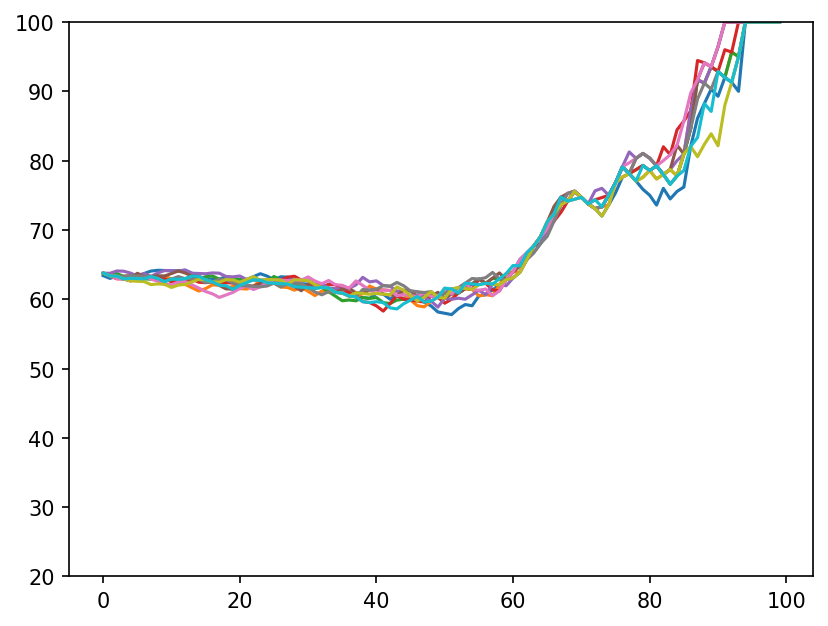

In [4]:
acc_all = []
for SEED in range(10):
    print(SEED)
    annfi_name = 'ann2_obs_'+EXP_NAME2+'_ann1-'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    ann = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)

    pred = ann.predict(X1test)
    acc = []
    predconf = np.max(pred,axis=-1)
    predval  = np.argmax(pred,axis=-1)

    for q in range(100):
        iconf = np.where(predconf >= np.percentile(predconf,q=q))
        icorr = np.where(predval[iconf] == Y1test[iconf])

        acc.append((len(icorr[0])/len(iconf[0]))*100)
    plt.plot(acc)
    plt.ylim(20,100)

    acc_all.append(acc)
plt.show()
np.save(base_dir+'test/confvsacc/confvsacc_ann2_obs_'+EXP_NAME2+'_ann1-'+EXP_NAME+'.npy', acc_all, allow_pickle=True)